In [81]:
import random

import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from numpy import ndarray

import pandas as pd

from typing import Type

from skimage import io
from skimage import transform

from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc

In [56]:
# Loading PneumoniaMNIST
pneu_data = np.load('pneumonia.npz')

# Extrating training data
pneu_train_data = pneu_data["train_images"]
pneu_train_labels = pneu_data["train_labels"]

# Extracting test data
pneu_test_data = pneu_data["test_images"]
pneu_test_labels = pneu_data["test_labels"]

# Extracting validation data
pneu_val_data = pneu_data["val_images"]
pneu_val_labels = pneu_data["val_labels"]

# Vectorizing data
vector_size = pneu_train_data.shape[1] * pneu_train_data.shape[2]

pneu_train_vdata = np.resize(pneu_train_data, (pneu_train_data.shape[0],vector_size))

pneu_test_vdata = np.resize(pneu_test_data, (pneu_test_data.shape[0],vector_size))

pneu_val_vdata = np.resize(pneu_val_data, (pneu_val_data.shape[0],vector_size))

In [46]:
# Loading BloodMNIST
blood_data = np.load('blood.npz')

# Extrating training data
blood_train_data = blood_data["train_images"]
blood_train_labels = blood_data["train_labels"]

# Extracting test data
blood_test_data = blood_data["test_images"]
blood_test_labels = blood_data["test_labels"]

# Extracting validation data
blood_val_data = blood_data["val_images"]
blood_val_labels = blood_data["val_labels"]

# Vectorizing data
vector_size = blood_train_data.shape[1] * blood_train_data.shape[2]

blood_train_vdata = np.resize(blood_train_data, (blood_train_data.shape[0],vector_size))

blood_test_vdata = np.resize(blood_test_data, (blood_test_data.shape[0],vector_size))

blood_val_vdata = np.resize(blood_val_data, (blood_val_data.shape[0],vector_size))

In [57]:
class KNN:
    def __init__(self, k):
        self.k = k

    def train(self, X, y):
        self.X_tr = X
        self.y_tr = y

    def comp_distances(self, X_tst):
        dst = np.zeros((X_tst.shape[0], self.X_tr.shape[0]))
        for i in range(X_tst.shape[0]):
            dst[i,:] = np.sum((self.X_tr - X_tst[i,:]) ** 2, axis = 1)
        return dst


    def predict(self, X_tst):
        dst = self.comp_distances(X_tst)

        yp = np.zeros(dst.shape[0])
        for i in range(dst.shape[0]):
            y_indx = np.argsort(dst[i,:])
            k_close = self.y_tr[y_indx[:self.k]]
            yp[i] = np.argmax(np.bincount(k_close))
        return yp

if __name__ == "__main__":

    X = pneu_test_vdata
    y = pneu_test_labels.ravel()

    # # hyperparameter(k) tuning using validation set
    # k_range = 10
    # acc = np.zeros(k_range)
    # for i in range(k_range):
    #     X = pneu_val_vdata
    #     y = pneu_val_labels.ravel()
    #     knn = KNN(k=i+1)
    #     knn.train(pneu_train_vdata, pneu_train_labels.ravel())
    #     y_pred = knn.predict(X)
    #     acc[i] = sum(y_pred == y) / y.shape[0]

    # plt.plot(np.arange(1, k_range+1), acc)
    # plt.show()

    knn = KNN(k=7)
    knn.train(pneu_train_vdata, pneu_train_labels.ravel())
    y_pred = knn.predict(X)
    print(f"Accuracy: {sum(y_pred == y) / y.shape[0]}")

Accuracy: 0.8349358974358975


In [58]:
class Logistic_Regression:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.m, self.n = X.shape

    def cost(self, w):
        yp = self.forward(w)
        return (-1/self.m) * np.sum(y * np.log(yp) + (1 - y) * np.log(1 - yp))

    def forward(self, w):
        yp = 1/(1 + np.exp(-(np.dot(self.X, w))))
        return yp

    def backward(self, yp):
        dw = (1/self.m) * np.sum((yp-self.y)*self.X, axis = 0)
        return dw.reshape((self.n, 1))

    def gd(self, w, dw, lr):
        w = w - lr * dw
        return w

    def train(self, lr, iter):
        w = np.zeros((self.n, 1))
        for i in range(iter):
            yp = self.forward(w)
            dw = self.backward(yp)
            w = self.gd(w, dw, lr)
        return w
    
        

if __name__ == "__main__":
    X = pneu_train_vdata
    y = pneu_train_labels
    X = np.append(np.ones((X.shape[0], 1)), X, axis = 1)

    learning_rate = 0.01
    no_iterations = 10000
    LR = Logistic_Regression(X, y)
    w = LR.train(learning_rate, no_iterations)
    cost = LR.cost(w)
    print('final_weights:', w)

    X_tst = np.append(np.ones((pneu_test_vdata.shape[0], 1)), pneu_test_vdata, axis = 1)
    ypr = 1/(1 + np.exp(-(np.dot(X_tst, w))))
    ypre = ypr > 0.5
    yt = pneu_test_labels
    print(f"Accuracy: {np.sum(yt==ypre)/pneu_test_vdata.shape[0]}")

/tmp/ipykernel_1098680/3627281565.py:12: RuntimeWarning: overflow encountered in exp
  yp = 1/(1 + np.exp(-(np.dot(self.X, w))))


final_weights: [[ 4.34722217e-02]
 [-6.66600020e+00]
 [-3.91409796e+00]
 [-2.85796447e+00]
 [-2.99359554e+00]
 [-8.63006318e-01]
 [ 4.04460244e+00]
 [ 7.84551258e-01]
 [-2.75732714e+00]
 [-5.01493202e+00]
 [-4.44623283e+00]
 [-5.32594791e+00]
 [-1.23810683e+01]
 [-1.35001885e+01]
 [-7.81475321e+00]
 [-7.46232936e+00]
 [-8.61682382e+00]
 [-3.48512010e+00]
 [ 4.58625976e+00]
 [ 9.84242769e+00]
 [ 8.55552050e+00]
 [ 4.00330178e+00]
 [ 1.84789140e+00]
 [-9.39335934e-02]
 [-2.08338711e+00]
 [-4.17262978e-02]
 [-2.36463267e+00]
 [-5.77150824e+00]
 [-6.14209664e+00]
 [-5.40659488e+00]
 [-2.82646476e+00]
 [-4.86372933e-02]
 [-6.16651105e-01]
 [-1.09161352e+00]
 [ 2.70677642e+00]
 [ 4.31676749e+00]
 [ 7.52872379e+00]
 [ 5.04771925e+00]
 [ 3.88274674e+00]
 [ 1.77763175e+00]
 [-4.97902280e+00]
 [-6.26706754e+00]
 [-2.40645835e+00]
 [-5.03454768e+00]
 [-9.55981599e+00]
 [-9.66518796e-01]
 [ 2.57537708e+00]
 [ 3.13354570e+00]
 [ 2.67122777e+00]
 [ 2.66990120e+00]
 [ 1.89651961e+00]
 [ 1.15513613e+0

/tmp/ipykernel_1098680/3627281565.py:9: RuntimeWarning: divide by zero encountered in log
  return (-1/self.m) * np.sum(y * np.log(yp) + (1 - y) * np.log(1 - yp))
/tmp/ipykernel_1098680/3627281565.py:9: RuntimeWarning: invalid value encountered in multiply
  return (-1/self.m) * np.sum(y * np.log(yp) + (1 - y) * np.log(1 - yp))
/tmp/ipykernel_1098680/3627281565.py:46: RuntimeWarning: overflow encountered in exp
  ypr = 1/(1 + np.exp(-(np.dot(X_tst, w))))


In [59]:
import numpy as np

class Linear_Regression:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.m, self.n = X.shape

    def cost(self, w):
        return (1/self.m) * np.sum((self.forward(w) - self.y)**2)

    def forward(self, w):
        return np.matmul(self.X, w)

    def backward(self, yp):
        dw = (2/self.m) * np.sum((yp-self.y)*self.X, axis = 0)
        return dw.reshape((self.n, 1))

    def gd(self, w, dw, lr):
        w = w - lr * dw
        return w

    def train(self, lr, iter):
        w = np.zeros((self.n, 1))
        for i in range(iter):
            yp = self.forward(w)
            dw = self.backward(yp)
            w = self.gd(w, dw, lr)
        return w
    
        

if __name__ == "__main__":
    # dataset creation
    X = np.random.rand(500, 4)
    k  = np.array([3, 7, 8, 9]).reshape(4, 1)
    k0 = 5
    y = np.dot(X, k) + k0


    X = np.append(np.ones((X.shape[0], 1)), X, axis = 1)
    learning_rate = 0.01
    no_iterations = 5000
    LR = Linear_Regression(X, y)
    w = LR.train(learning_rate, no_iterations)
    cost = LR.cost(w)
    print('final_weights:', w)
    print('loss:', cost)

final_weights: [[5.0748714 ]
 [2.96398864]
 [6.95436138]
 [7.96705825]
 [8.97145325]]
loss: 0.00042958802196938167


In [60]:
class NaiveBayes:
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        # calculate mean, var, and prior for each class

        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            self._mean[idx, :] = X_c.mean(axis=0)
            self._var[idx, :] = X_c.var(axis=0)
            self._priors[idx] = X_c.shape[0] / float(n_samples)

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        posteriors = []

        # calculate posterior probability for each class
        for idx, c in enumerate(self._classes):
            prior = np.log(self._priors[idx])
            posterior = np.sum(np.log(self._pdf(idx, x)))
            posterior = prior + posterior
            posteriors.append(posterior)

        # return class with highest posterior probability
        return self._classes[np.argmax(posteriors)]

    def _pdf(self, class_idx, x):
        mean = self._mean[class_idx]
        var = self._var[class_idx]
        numerator = np.exp(-((x - mean) ** 2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

In [64]:
train_X=pneu_train_vdata
train_y=np.ravel(pneu_train_labels)
test_X=pneu_test_vdata
test_y=np.ravel(pneu_test_labels)
nb = NaiveBayes()
nb.fit(train_X, train_y)
predictions = nb.predict(test_X)
accuracy = np.sum(test_y== predictions) / len(test_y)
accuracy

0.8333333333333334

In [65]:
class GuassianDensity():
    def __init__(self,dim : int = 1, params : list = None, params_dtype : Type = np.float32) -> None:
        self.dim= dim
        self.mean = np.ones((dim), dtype = params_dtype)
        self.covariance = np.ones((dim,dim), dtype = params_dtype)

        if(params != None and self.dim == params[0].shape[0]):
            self.set_params(params[0], params[1])

        self.const = 1/((2*np.pi)**0.5)**dim

        if(dim == 1):
            self.det_covariance = self.covariance[0,0]
        else:
            self.det_covariance = np.linalg.det(self.covariance)
        
        if(dim == 1 or self.det_covariance == 0):
            self.inv_covariance = self.covariance
        else:
            self.inv_covariance = np.linalg.inv(self.covariance)
        
    def set_params(self, mean : ndarray, covariance : ndarray):
        if(self.mean.shape == mean.shape and self.covariance.shape == covariance.shape):
            del self.mean
            del self.covariance
                
            self.mean = mean.copy()
            self.covariance = covariance.copy()
                
            if(self.dim == 1):
                self.det_covariance = self.covariance[0,0]
            else:
                self.det_covariance = np.linalg.det(self.covariance)
        
            if(self.dim == 1 or self.det_covariance == 0):
                self.inv_covariance = self.covariance
            else:
                self.inv_covariance = np.linalg.inv(self.covariance)
        else:
            if(self.mean.shape != mean.shape):
                print("Mismatching dimension for mean: Required",self.mean.shape,"Given",self.mean.shape)
            elif(self.covariance.shape != covariance.shape):
                print("Mismatching dimensions for covariance: Required",self.covariance.shape,"Given",covariance.shape)

    def get_value(self,x : ndarray):
        if(self.mean.shape == x.shape):
            val = self.const
            val = val/self.det_covariance
            
            diff_vec = x - self.mean
            
            diff_vec = np.expand_dims(diff_vec,axis=0)
            
            exponent = np.exp(-0.5*(np.matmul(np.matmul(diff_vec,self.inv_covariance),np.transpose(diff_vec))))
                
            return val*exponent
        else:
            print("Mismatching dimension for input vector: Required",self.mean.shape,"Given",x.shape)

In [66]:
class ExponentialDensity():
    def __init__(self,dim : int = 1,params : ndarray = None,params_dtype : Type = np.float32) -> None:
        self.dim = dim
        self.lamb = np.ones((dim),dtype=params_dtype)

        if(isinstance(params,ndarray) and self.dim == params.shape[0]):
            for i in range(self.dim):
                self.lamb[i] = params[i]
        
    def set_params(self,lamb : ndarray):
        if(self.lamb.shape == lamb.shape):
            del self.lamb
            
            self.lamb = lamb.copy()
        else:
            print("Mismatching dimension for lambda: Required",self.lamb.shape,"Given",lamb.shape)
            
    def get_params(self):
        return self.lamb.copy()
    
    def get_value(self,x : ndarray):
        if(x.shape == self.lamb.shape):
            lamb_prod = 1
            
            for i in range(self.dim):
                lamb_prod = lamb_prod * self.lamb[i]

            lamb = self.lamb.copy()
            lamb = np.expand_dims(lamb,axis=0)

            exponent = np.exp(-1*(np.matmul(self.lamb,np.transpose(x))))

            del lamb

            return lamb_prod*exponent
        else:
            print("Mismatching dimension for input vector: Required",self.lamb.shape,"Given",x.shape)

In [67]:
#Density codes
GUASSIAN_DENSITY = 0
EXPONENTIAL_DENSITY = 1

In [69]:
#Estimate codes
ML_ESTIMATE = 0
BAYES_ESTIMATE = 1

def ML_Estimate(data_points : ndarray, density = GUASSIAN_DENSITY, stretch_dimensions = True):
    size, dim = data_points.shape[0], data_points.shape[1:]

    if(stretch_dimensions == True):
        new_dim = 1
        
        for i in dim:
            new_dim = new_dim * i

        new_data = np.zeros((size,new_dim),dtype=data_points.dtype)
        
        for i in range(size):
            new_data[i] = data_points[i].ravel()
            
        del data_points
        
        data_points = new_data
        
        size, dim = data_points.shape

    if(density == GUASSIAN_DENSITY):
        mean = np.zeros(dim)
        
        for i in range(size):
            mean += data_points[i]
        
        mean = mean/size
        
        covariance = np.zeros((dim,dim))
        
        for i in range(size):
            diff = data_points[i] - mean
            
            diff = np.expand_dims(diff,axis=0)

            covariance += np.matmul(np.transpose(diff), diff)
            covariance /= size
        
        return GuassianDensity(dim,[mean, covariance])
    elif(density == EXPONENTIAL_DENSITY):
        statistic = np.zeros(dim)
        
        for i in range(size):
            statistic += data_points[i]
            
        lamb = size/statistic

        return ExponentialDensity(dim,lamb)
        
    else:
        print("Invalid density model for ML Estimate")
        
def MAPEstimate(data_points : ndarray, density : GUASSIAN_DENSITY, stretch_dimensions = True):
    pass

In [73]:
class BayesClassifier:
    __IMPLEMENTED_DENSITIES = [GUASSIAN_DENSITY,EXPONENTIAL_DENSITY]
    __IMPLEMENTED_ESTIMATES = [ML_ESTIMATE,BAYES_ESTIMATE]
    
    def __init__(self,num_classes : int, class_densities : list = None, class_priors : ndarray = None) -> None:
        self.num_classes = num_classes
        
        self.__class_densities_codes = list()
        
        for i in range(self.num_classes):
            self.__class_densities_codes.append(GUASSIAN_DENSITY)

        if class_densities != None:
            for i in range(len(class_densities)):
                if class_densities[i] in BayesClassifier.__IMPLEMENTED_DENSITIES:
                    self.__class_densities_codes.append(class_densities[i])
        
        self.class_priors = list()
        
        if(class_priors != None):
            if(self.num_classes == class_priors.shape[0] and np.sum(class_priors) == 1):
                for prior in range(self.num_classes):
                    self.class_priors.append(prior)
            else:
                print("Invalid class priors: Switching to default")
                
        self.train_count = 0
    def train(self, data_points : ndarray, labels : ndarray, estimation_method = ML_ESTIMATE):
        if(len(labels.shape) != 1):
            print("Error: Labels should be 1-d array")
            return
        
        classes = np.unique(labels)

        num_classes = classes.shape[0]

        if(self.num_classes != num_classes):
            print("Number of classes in label set didn't match with classifier classes")
            return
        
        data_size, dim = data_points.shape[0], data_points[1:]
        label_size = labels.shape[0]
        
        if(data_size == label_size):
            if estimation_method not in self.IMPLEMENTED_ESTIMATES:
                print("Warning: Given estimated method is not implemented in this version yet, defaulting to ML Estimation")
                return
                
            class_wise_data = dict()
            
            for i in range(data_size):
                if labels[i] in class_wise_data:
                    class_wise_data[labels[i]].append(data_points[i])
                else:
                    class_wise_data[labels[i]] = list()
                
            if estimation_method == ML_ESTIMATE:
                self.class_densities = list()
                
                for i in range(self.num_classes):
                    self.class_densities.append(ML_Estimate(np.array(class_wise_data[i]),self.__class_densities_codes[i]))
                    
            self.train_count += 1
        else:
            print("Error: Mismatch between number of data points and number of labels provided")
    def classify(self, data_points : ndarray, true_labes):
        data_size, dim = data_points[0], data_points[1:]
        
        labels = np.zeros((data_size))
        probs = np.zeros((self.num_classes))
        
        for i in range(data_size):
            for j in range(self.num_classes):
                probs[j] = self.class_densities[j].get_value(data_points[i])
                
            labels[i] = np.argmax(probs)
        
        return labels

In [75]:
classifier = BayesClassifier(2)
classifier.train(pneu_train_vdata, pneu_train_labels)
classifier.classify(pneu_test_vdata, pneu_test_labels)

Error: Labels should be 1-d array


ValueError: maximum supported dimension for an ndarray is 32, found 784

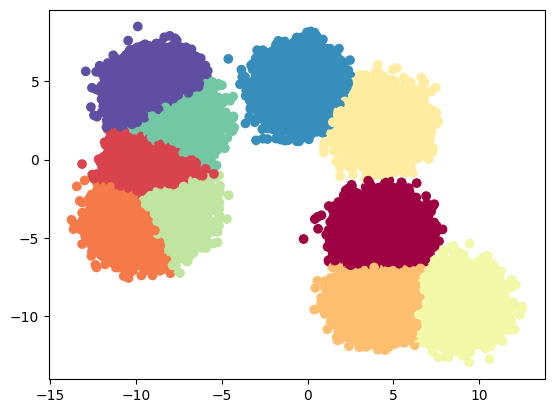

In [120]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

class kmeans:
    def __init__(self, X, k, no_iter):
        self.k = k
        self.X = X
        self.m, self.n = X.shape
        self.iter = no_iter


    def centres(self):
        c_in = np.zeros((self.k, self.n))

        for i in range(self.k):
            centroid = X[np.random.randint(1, self.m)]
            c_in[i] = centroid

        dist = np.zeros((self.m, self.k))
        clusters = []
        for j in range(self.iter):
            for i in range(self.k):
                dist[:, i] = np.sum((self.X - c_in[i, :])**2, axis = 1)
            ind = np.argmin(dist, axis = 1)
            for i in range(self.k):
                    l = np.where(ind == i)
                    clusters.append(l)
                    c_in[i] = np.mean(self.X[l], axis = 0)
        return c_in, clusters


if __name__ == "__main__":
    num_clusters = 10
    X, _ = make_blobs(n_samples=100000, n_features=2, centers=num_clusters)

    Km = kmeans(X, num_clusters, 100)
    C, clusters = Km.centres()

    y = np.zeros(X.shape[0])

    for cluster_idx, cluster in enumerate(clusters):
        for sample_idx in cluster:
            y[sample_idx] = cluster_idx
    
    plt.scatter(X[:, 0], X[:, 1], c = y, cmap = plt.cm.Spectral)
    plt.show()

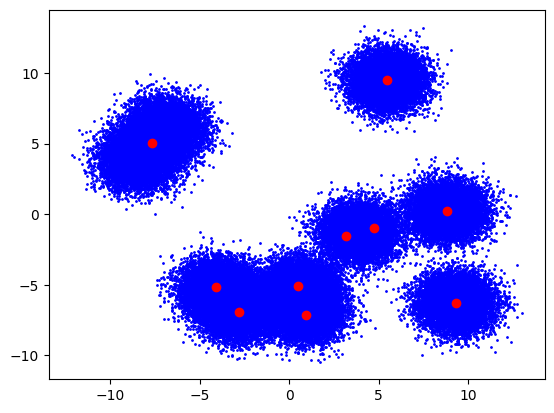

In [121]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

class kmeans:
    def __init__(self, X, k, no_iter):
        self.k = k
        self.X = X
        self.m, self.n = X.shape
        self.iter = no_iter


    def centres(self):
        c_in = np.zeros((self.k, self.n))

        for i in range(self.k):
            centroid = X[np.random.choice(range(self.m))]
            c_in[i] = centroid

        dist = np.zeros((self.m, self.k))
        for j in range(self.iter):
            for i in range(self.k):
                dist[:, i] = np.sum((self.X - c_in[i, :])**2, axis = 1)
            ind = np.argmin(dist, axis = 1)
            for i in range(self.k):
                    l = np.where(ind == i)
                    c_in[i] = np.mean(self.X[l], axis = 0)

        return c_in


if __name__ == "__main__":
    num_clusters = 10
    X, _ = make_blobs(n_samples=100000, n_features=2, centers=num_clusters)

    Km = kmeans(X, num_clusters, 100)
    c = Km.centres()
    
    plt.scatter(X[:, 0], X[:, 1], c = 'b', s = 1)
    plt.scatter(c[:, 0], c[:, 1], c = 'r')
    plt.show()

(50000, 2)


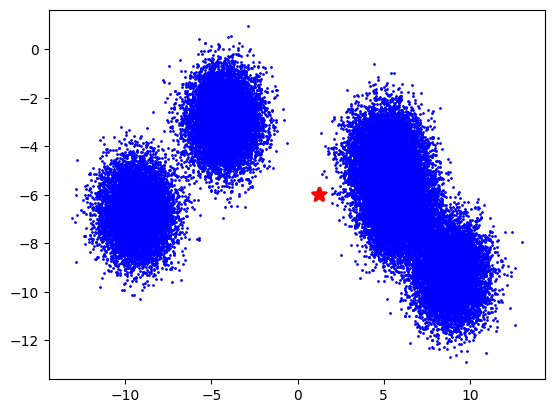

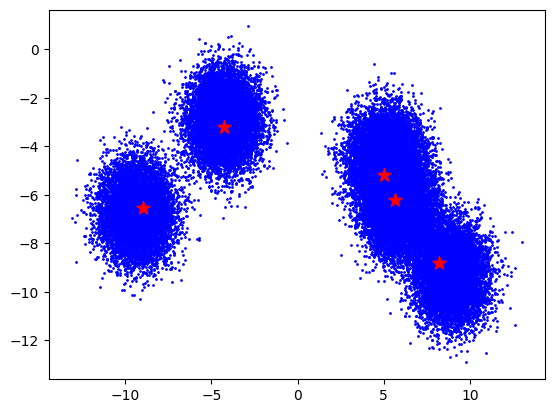

In [119]:
from copy import deepcopy
# data = pd.read_csv('xclara.csv')

# f1 = data['V1']
# f2 = data['V2']
# X = np.array(list(zip(f1, f2)))
num_clusters = 5

X, _ = make_blobs(n_samples=50000, n_features=2, centers=num_clusters)
print(X.shape)

n, d = X.shape     # number of data points, dimension
k = num_clusters   # number of clusters
m = 2              # fuzzy parameter
MAX_ITERS = 500    # number of iterations

def initializeMembershipWeights():
    W =  np.random.dirichlet(np.ones(k),n)
    W = np.array(W)
    return W

W_in = initializeMembershipWeights()

def computeCentroids(W):
  C = np.zeros((k, d))
  for i in range(k):
    for j in range(d):
      C[i, j] = np.sum(np.power(W[:,i],m) * X[:, j])/np.power(W[:,i],m).sum()
  return C 
C_in  = computeCentroids(W_in)

plt.figure()
plt.scatter(X[:, 0], X[:, 1], c='b', s=1)
plt.scatter(C_in[:, 0], C_in[:, 1], marker = '*', c='r', s = 100)
plt.show()

def updateWeights(W, C):
  denom = np.zeros(n)
  for i in range(k):
    dist = (X - C[i])**2
    dist = np.sum(dist, axis=1)
    dist = np.sqrt(dist)
    denom  = denom + np.power(1/dist,1/(m-1))

  for i in range(k):
    dist = (X - C[i])**2
    dist = np.sum(dist, axis=1)
    dist = np.sqrt(dist)
    W[:,i] = np.divide(np.power(1/dist,1/(m-1)),denom)
  return W

# def FuzzyMeansAlgorithm():
#   W = initializeMembershipWeights()
#   for i in range(MAX_ITERS):
#     C = computeCentroids(W)
#     W = updateWeights(W, C)
#   return W, C

def FuzzyMeansAlgorithm():
  W = initializeMembershipWeights()
  t = 1
  while t>0.005:
    C = computeCentroids(W)
    W_old = deepcopy(W)
    W = updateWeights(W, C)
    t = np.linalg.norm(W_old.ravel()-W.ravel())
  return W, C

W_final, C_final = FuzzyMeansAlgorithm()

plt.figure()
plt.scatter(X[:, 0], X[:, 1], c='b', s=1)
plt.scatter(C_final[:, 0], C_final[:, 1], marker = '*', c='r', s = 100)
plt.show()